# Using `PySINDy` package for discovering dynamics form data. Comparing differantion methods available in the package

The code in this notebook is adapted based on the examples from [pysindy.readthedocs.io/en/latest/](pysindy.readthedocs.io/en/latest/).

We begin with loading necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pysindy as ps

## Example 1: approximating a derivative of a sine function.

We consider a function $y(t) = \sin(t)$, for which the true derivative is $y^\prime(t) = -\cos(t)$.

In [2]:
def sine_data(n: int, noise_level: float):
    # observed t in [0, 2pi]; n equaly spaced observations are taken 
    t = np.linspace(0, 2, n) * np.pi

    # observe y = sin(t)
    y = np.sin(t)

    # true (analytical) derivative evaluated at x, y'(t)
    y_prime = np.cos(t)

    # adding noise to the observations, given `noise_level`
    np.random.seed(314)
    noise = noise_level * np.random.normal(n)
    y_noisy = y + noise

    return t, y, y_noisy, y_prime


# generating data (noise level = 0.1)
t, y, y_noisy, y_prime = sine_data(25, 0.1)

Let's define differention methods available in the `PySINDy` package to compare.

In [3]:
differentiation_methods = [
    ("PySINDy FD", ps.FiniteDifference()),
    ("PySINDy Smoothed FD", ps.SmoothedFiniteDifference()),
    ("PySINDy Spectral", ps.SpectralDerivative()),
    ("derivative FD", ps.SINDyDerivative(kind="finite_difference", k=1)),
    ("derivative spline", ps.SINDyDerivative(kind="spline", s=1e-2)),
    ("derivative spectral", ps.SINDyDerivative(kind="spectral")),
    ("derivative TF", ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)),
    ("derivative Kalman", ps.SINDyDerivative(kind="kalman", alpha=0.05)),
    ("derivative kernel", ps.SINDyDerivative(kind="kernel", sigma=1, lmbd=.1, kernel="rbf"))
]

Now, let's approximate derivative and visualize the results.

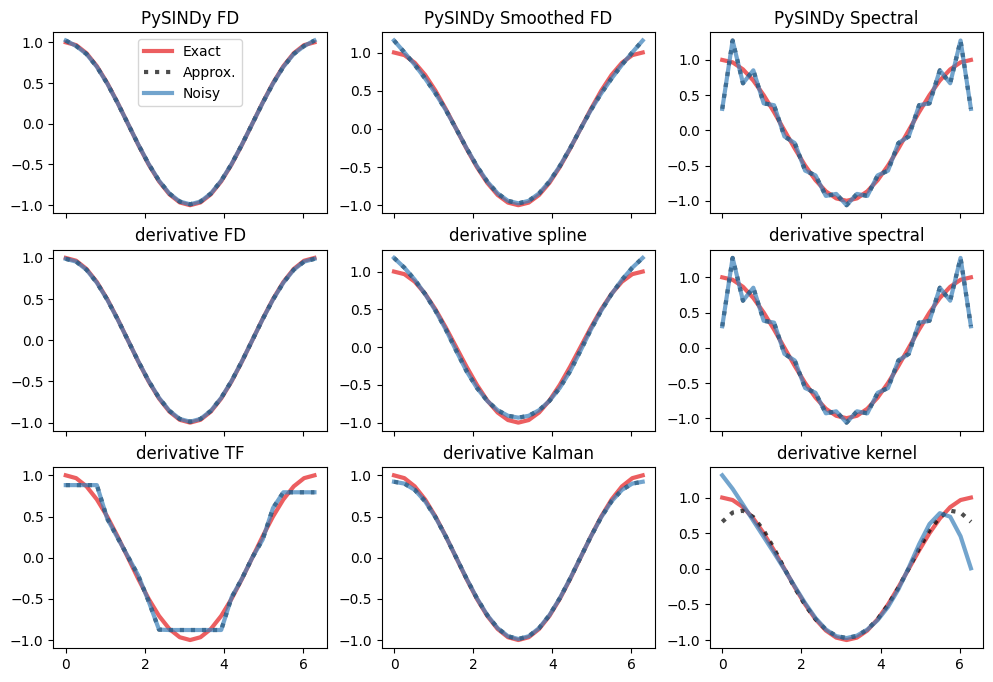

In [4]:
def compare_differentiation_methods(differentiation_methods, t, y, y_noisy, y_prime):
    palette = sns.color_palette("Set1")
    plot_kwargs = dict(alpha=0.7, linewidth=3)

    n_methods = len(differentiation_methods)
    n_cols = 3
    n_rows = n_methods // n_cols + int(n_methods % n_cols > 0)
    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 8), sharex=True)

    for (method_name, method), ax in zip(differentiation_methods, axes.flatten()):
        ax.plot(t, y_prime, label="Exact", color=palette[0], **plot_kwargs)
        ax.plot(t, method(y, t), ":", label="Approx.", color="black", **plot_kwargs)
        ax.plot(t, method(y_noisy, t), label="Noisy", color=palette[1], **plot_kwargs)
        ax.set(title=method_name)

        axes[0, 0].legend()

    return fig

fig = compare_differentiation_methods(differentiation_methods, t, y, y_noisy, y_prime)
fig
plt.savefig("figures/lecture05-ex02a.png", dpi = 300)  

## Example 2: approximating a derivative of an absolute value function

Here, we consider a function $y(t) = |t|$, for which the true derivative is defined as $y^\prime(t) = \text{sign}(t)$.

In [5]:
def abs_val_data(n:int, noise_level: float):
    # observed t in [-1, 1]; n equaly spaced observations are taken 
    t = np.linspace(-1, 1, n)

    # observe y = sin(t)
    y = np.abs(t)

    # true (analytical) derivative evaluated at x, y'(t)
    y_prime = np.sign(t)

    # adding noise to the observations, given `noise_level`
    np.random.seed(314)
    noise = noise_level * np.random.normal(n)
    y_noisy = y + noise

    return t, y, y_noisy, y_prime


# generating data (noise level = 0.1)
t, y, y_noisy, y_prime = abs_val_data(25, 0.1)

Comparing differentiation methods for $y(t) = |t|$.

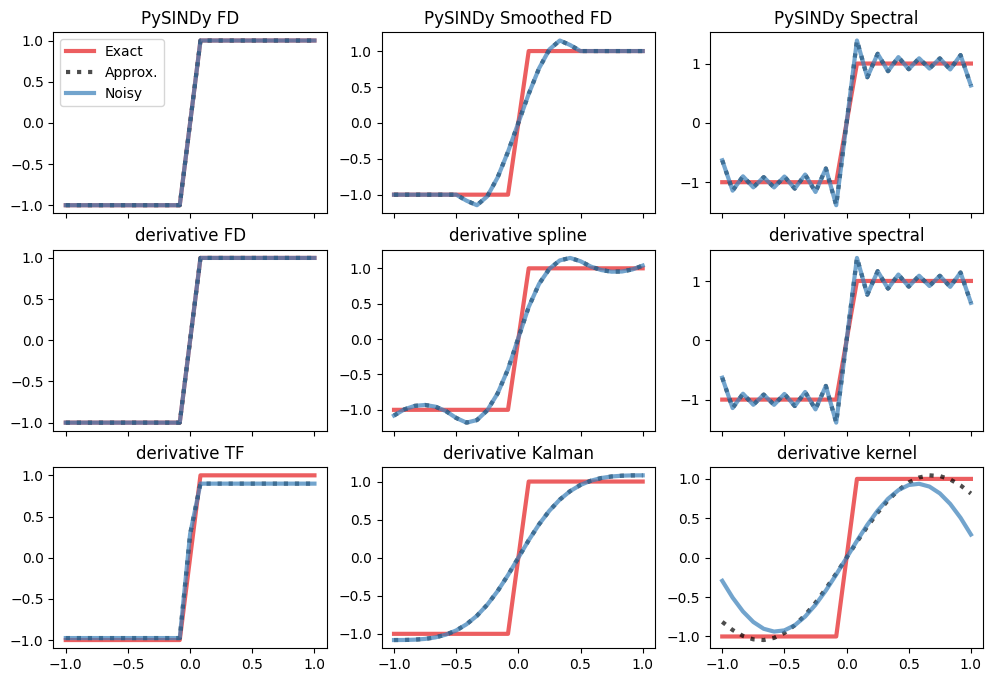

In [6]:
fig = compare_differentiation_methods(differentiation_methods, t, y, y_noisy, y_prime)
fig
plt.savefig("figures/lecture05-ex02b.png", dpi = 300)  

## Example 3: linear ocsillator

Now, let's consider a system of two linear differantial equations (a linear ocsillator) and apply SINDy to discover the system dynamics, using different approaches for approaximating derivatives.

$$
\left\{\begin{aligned}
\dot{x} &= -0.1x + 2y \\
\dot{y} &= -2x -0.1y 
\end{aligned}\right. \Leftrightarrow
\frac{d}{dt}\underbrace{\begin{pmatrix}x\\y\end{pmatrix}}_{\mathbf{X}} = \underbrace{\begin{pmatrix}-0.1 & 2 \\ -2 & -0.1\end{pmatrix}}_{\mathbf{A}}\underbrace{\begin{pmatrix}x\\y\end{pmatrix}}_{\mathbf{X}} = \dot{\mathbf{X}} = \mathbf{A}\mathbf{X}.
$$

In [27]:
# a python function, defining the corresponding system of ODEs is available in `pysindy.utils`
from pysindy.utils import linear_damped_SHO

# from scipy.integrate, importing a function, solving initial valiue problem (IVP)
from scipy.integrate import solve_ivp

def linear_oscillator_data(t0:float, tmax:float, dt:float, noise_level:float, integrator_kwargs: dict):
    t = np.arange(t0, tmax, dt)
    t_span = (t[0], t[-1])
    X0 = [2, 0]
    X = solve_ivp(linear_damped_SHO, t_span, X0, t_eval=t, **integrator_kwargs).y.T
    X_noisy = X + noise_level * np.random.randn(*X.shape)
    return dt, t, X, X_noisy

integrator_kwargs = {"rtol": 1e-12, "atol": 1e-12, "method": "LSODA"}

# generating data (noise level = 0.1)
dt, t, X, X_noisy = linear_oscillator_data(0, 10, 0.01, 0.1, integrator_kwargs)

Visualizing observed data and true trajectory.

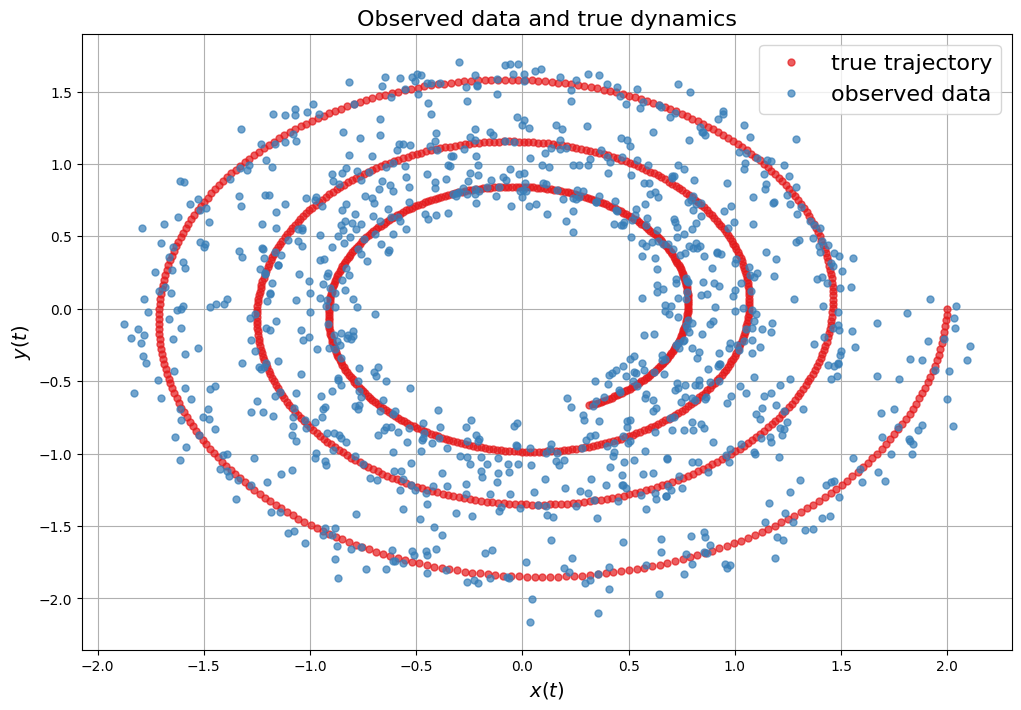

In [28]:
palette = sns.color_palette("Set1")
plot_kwargs = dict(alpha=0.7, linewidth=3)

plt.figure(figsize=(12, 8))
plt.plot(X[:, 0], X[:, 1], ".", markersize = 10, label="true trajectory", color=palette[0], **plot_kwargs)
plt.plot(X_noisy[:, 0], X_noisy[:, 1], ".", markersize = 10, label="observed data", color=palette[1],**plot_kwargs)
plt.xlabel(r"$x(t)$", fontsize=14)
plt.ylabel(r"$y(t)$", fontsize=14)
plt.title("Observed data and true dynamics", fontsize=16)
plt.legend(fontsize = 16)
plt.grid()
plt.savefig("figures/lecture05-ex02c.png", dpi = 300)

Let's apply SINDy algorithm to discover the dynamics, using different approaches to 
approximating derivatives.

In [45]:
equations_clean = {}
equations_noisy = {}
coefficients_clean = {}
coefficients_noisy = {}

# setting the optimizer
opt = ps.STLSQ(threshold=0.05)
dt = 0.01
for method_name, method in differentiation_methods:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=opt,
        t_default=dt,
        feature_names=("x", "y"),
        feature_library=ps.PolynomialLibrary()
    )
    model.fit(X, quiet=True)
    equations_clean[method_name] = model.equations()
    coefficients_clean[method_name] = model.coefficients()

    model.fit(X_noisy, quiet=True)
    equations_noisy[method_name] = model.equations()
    coefficients_noisy[method_name] = model.coefficients()

In [46]:
def print_equations(equations_clean, equations_noisy):
    print(f"{'':<30} {'Noiseless':<40} {'Noisy':<40}")

    for name in equations_clean.keys():
        print(f"{name:<30} {'':<40} {'':<40}")

        for k, (eq1, eq2) in enumerate(
            zip(equations_clean[name], equations_noisy[name])
        ):
            print(
                f"{'':<30} {'x' + str(k) + '=' + str(eq1):<40} {'x' + str(k) + '=' + str(eq2):<40}"
            )

        print(
            "-------------------------------------------------------------------------------------------"
        )

print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
PySINDy FD                                                                                                      
                               x0=-0.100 x + 2.000 y                    x0=-0.116 x + 1.967 y + -0.057 x y      
                               x1=-2.000 x + -0.100 y                   x1=-0.186 1 + -1.975 x + -0.086 y + 0.152 x^2 + 0.054 y^2
-------------------------------------------------------------------------------------------
PySINDy Smoothed FD                                                                                             
                               x0=-0.100 x + 2.000 y                    x0=-0.063 x + 1.978 y                   
                               x1=-2.000 x + -0.100 y                   x1=-1.997 x + -0.110 y                  
-------------------------------------------------------------------------------------------
PySINDy 